In [1]:
%pylab inline
import pandas as pd
import dask.dataframe as dd
import os,sys
import logging
import fastparquet
import gc
import cPickle as pickle 

Populating the interactive namespace from numpy and matplotlib


In [2]:
sys.path.insert(0,"../python/")

### A

In [3]:
from zillow import features,config,info
reload (info)

<module 'zillow.info' from '../python/zillow/info.pyc'>

In [4]:
def error(yhat,y):
    yhat=np.log(yhat)
    y=np.log(y)
    e=np.abs(yhat-y)
    l1=np.mean(e)
    e[e>0.4]=0.4
    return float(np.mean(e)),float(l1)

In [5]:
reload(features)
def read_pred(state,year,prefix):
    filename=os.path.join(config.get_state_year_folder2(state,year),'combined_{}_prediciton.parq'.format(prefix))
    df=dd.read_parquet(filename).compute()
    df.month=df.month+year*100 
    
    if prefix in ['woofinal', 'final']:
        price_col_name='yb_{}_zip5_saleprice'.format(year)
    else:
        price_col_name='yb_{}_model_saleprice'.format(year)
        
    def add_zip(df):
        df2 = features.make_block_dict(state)
        df['rawcensustractandblock'] = df.index.map(lambda u: df2[u])
        df['tract'] = df['rawcensustractandblock'].map(lambda u: u[:11])
        df2 =features. make_county_dict(state)
        df['county'] = df['rawcensustractandblock'].map(lambda u: u[:5])

        df2 = features.make_zip5_dict(state)
        #print state, str(list(df.index.difference(df2.keys())))

        df['zip5'] = df.index.map(lambda u: df2[u])
        df['zip3'] = df['zip5'].map(lambda u: u[:3])
        return df
    df=add_zip(df)
    return df

In [6]:
def check(df,year,prefix):
    if prefix in ['woofinal', 'final']:
        price_col_name='yb_{}_zip5_saleprice'.format(year)
    else:
        price_col_name='yb_{}_model_saleprice'.format(year)
        
        
    df=df[~df['saleprice'].isnull()]
    if prefix in ['woofinal', 'final']:
        hpiobj = info.HpiDiscount('zip5')
    else:
        hpiobj = info.HpiDiscount('modelext')
    def f(u):
        county, zip3, zip5, block, month1 = u
        month0=year*100+1
        return hpiobj.ratio(month0, int(month1), state, county, zip3, zip5, block)
    df['ratio'] = df[["county", 'zip3', 'zip5', 'rawcensustractandblock',  'month']].apply(f, axis=1)

    for col in [u'meanpred', u'medianpred', u'geomeanpred', u'optimizedpred']:
        print col, error(df[col].values, df[price_col_name].values)
    print "with raw"
    for col in [u'meanpred', u'medianpred', u'geomeanpred', u'optimizedpred']:
        print col, error(df[col].values*df['ratio'], df.saleprice.values)

    def g(subdf):
        _,u,v=subdf.values.T
        return error(u,v)[0]
    lst=[]
    for col in [u'meanpred', u'medianpred', u'geomeanpred', u'optimizedpred']:

        a=df[['month',col, price_col_name]].groupby(['month']).apply(g).to_frame()
        lst.append(a)
    a=pd.concat(lst,axis=1)
    a.columns=[u'meanpred', u'medianpred', u'geomeanpred', u'optimizedpred']
    display(a)
    a.plot(kind='bar')
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.show()    

In [7]:
def run(year,prefix):
    pred1=pd.concat([read_pred(state,year,prefix) for state in config.STATES],axis=0)   
    check(pred1,year,prefix)

meanpred (0.1297687143087387, 0.18601830303668976)
medianpred (0.12949630618095398, 0.1846216768026352)
geomeanpred (0.12972237169742584, 0.18534839153289795)
optimizedpred (0.1294267773628235, 0.18346227705478668)
with raw
meanpred (0.12975894286206788, 0.18601123017744345)
medianpred (0.129489135109643, 0.18461555581485425)
geomeanpred (0.1297124069517005, 0.18534042087854263)
optimizedpred (0.12941554493699334, 0.18345003808260585)


/home/lizhen09/miniconda2/envs/python27/lib/python2.7/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


meanpred  medianpred  geomeanpred  optimizedpred
month                                                     
201801.0  0.135813    0.135444     0.135715       0.135391
201802.0  0.135164    0.134637     0.135011       0.134597
201803.0  0.128480    0.128451     0.128545       0.128520
201804.0  0.127666    0.127483     0.127676       0.127285
201805.0  0.124440    0.124082     0.124329       0.123968
201806.0  0.122343    0.122076     0.122403       0.121823

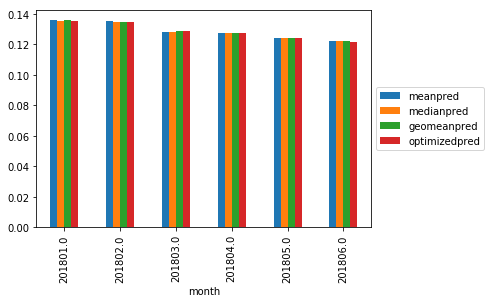

In [43]:
run(2018, 'final')

meanpred (0.1295449435710907, 0.18740743398666382)
medianpred (0.12933088839054108, 0.18644821643829346)
geomeanpred (0.12952794134616852, 0.1872197538614273)
optimizedpred (0.12933829426765442, 0.18568280339241028)
with raw
meanpred (0.1295359783392868, 0.18740192901523822)
medianpred (0.12932118825458613, 0.18644223041118596)
geomeanpred (0.1295186273165324, 0.18721405418524809)
optimizedpred (0.1293221405036579, 0.18566914737336013)


/home/lizhen09/miniconda2/envs/python27/lib/python2.7/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


meanpred  medianpred  geomeanpred  optimizedpred
month                                                     
201801.0  0.135537    0.135236     0.135487       0.135190
201802.0  0.134871    0.134516     0.134811       0.134503
201803.0  0.128351    0.128237     0.128368       0.128231
201804.0  0.127176    0.127095     0.127190       0.127265
201805.0  0.124440    0.124183     0.124416       0.124127
201806.0  0.122824    0.122303     0.122770       0.121907

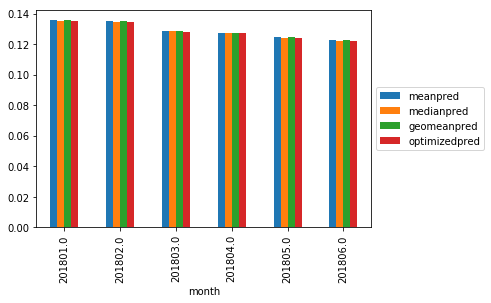

In [44]:
run(2018, 'woofinal')

meanpred (0.12919071316719055, 0.1870659589767456)
medianpred (0.12896691262722015, 0.1860431581735611)
geomeanpred (0.12917432188987732, 0.1868581771850586)
optimizedpred (0.12898191809654236, 0.18539699912071228)
with raw
meanpred (0.1291891892208261, 0.1870627640395662)
medianpred (0.12896571731877146, 0.18604021785664848)
geomeanpred (0.1291729427397867, 0.1868551373925833)
optimizedpred (0.1289808463955269, 0.18539418356171886)


/home/lizhen09/miniconda2/envs/python27/lib/python2.7/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


meanpred  medianpred  geomeanpred  optimizedpred
month                                                     
201801.0  0.135100    0.134747     0.135031       0.134563
201802.0  0.134578    0.134256     0.134520       0.134150
201803.0  0.128061    0.127968     0.128084       0.128047
201804.0  0.126594    0.126483     0.126597       0.126570
201805.0  0.124231    0.123963     0.124228       0.124085
201806.0  0.123050    0.122386     0.123042       0.122575

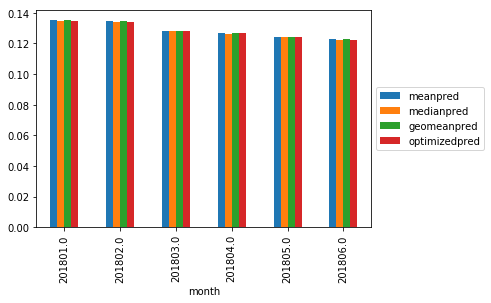

In [45]:
run(2018, 'woomodelhpifinal')

In [8]:
reload(info)

<module 'zillow.info' from '../python/zillow/info.py'>

In [9]:
def fill_missing(df):
    missed= dd.read_parquet('../input/info/missed_parcelid_county.parq').compute()
    missed['state']=missed['county'].map(lambda u: u[:2])
    county_med=df[['county','201809']].groupby('county').median()['201809'].to_dict()
    missed['201809']=missed['county'].map(lambda u: county_med[u])
    county_med=df[['county','201810']].groupby('county').median()['201810'].to_dict()
    missed['201810']=missed['county'].map(lambda u: county_med[u])    
    return missed

In [10]:
def make_pred(year,prefix,hpi=None):
    if hpi is None:
        if prefix in ['woofinal', 'final']:
            hpi='zip5'
        else:
            hpi='modelext'
    hpiobj = info.HpiDiscount(hpi)   

    df=pd.concat([read_pred(state,year,prefix) for state in config.STATES],axis=0)   
    sample=pd.read_csv("../input/raw_input/sample_submission.csv",index_col=0)
    print sample.shape,df.shape #some are missing due to bug
    #print str(list(sample.index.difference(df.index)))

    for i in [9,10]:
        this_month=year*100+i
        df['month']=this_month
             
        def f(u):
            county, zip3, zip5, block, month1 = u
            month0=year*100+1
            return hpiobj.ratio(month0, int(month1), state, county, zip3, zip5, block)
        df['ratio'] = df[["county", 'zip3', 'zip5', 'rawcensustractandblock',  'month']].apply(f, axis=1)
        df[str(this_month)]=df['ratio']*df['medianpred']
        display(df.head())
        sample.loc[df.index,str(this_month)]=df[str(this_month)]
    
    display((sample==0).mean())
    missed=fill_missing(df)
    sample.loc[missed.index,'201809']=missed['201809']
    sample.loc[missed.index,'201810']=missed['201810']
    display((sample==0).mean())
    sample=np.round(sample,2)
    sample.to_csv('../input/submission_{}_{}.csv'.format(prefix,hpi))
    return sample,df

In [16]:
_,df=make_pred(2018, 'final')

(9463187, 4) (9424744, 12)


meanpred   medianpred  geomeanpred  optimizedpred  \
parcelid                                                         
8921076   635013.6250  633320.7500  634955.3750    636623.8125   
8921077   642220.5000  642560.3125  642186.4375    643620.4375   
8921078   655398.5000  652570.3125  655316.0000    657534.7500   
8921079   654165.8750  651280.3125  654079.1250    655874.9375   
8921080   793047.0625  794043.5625  792986.8125    793134.3125   

          yb_2018_zip5_saleprice  saleprice   month rawcensustractandblock  \
parcelid                                                                     
8921076                      NaN        NaN  201809        060014033001030   
8921077                      NaN        NaN  201809        060014033001030   
8921078                      NaN        NaN  201809        060014033001030   
8921079                      NaN        NaN  201809        060014033001030   
8921080                      NaN        NaN  201809        060014033001030   

                tract county   zip5 zip3     ratio         201809  
parcelid                                                           
8921076   06001403300  06001  94607  946  1.035959  656094.093862  
8921077   06001403300  06001  94607  946  1.035959  665665.898332  
8921078   06001403300  06001  94607  946  1.035959  676035.844176  
8921079   06001403300  06001  94607  946  1.035959  674699.457549  
8921080   06001403300  06001  94607  946  1.035959  822596.277834

meanpred   medianpred  geomeanpred  optimizedpred  \
parcelid                                                         
8921076   635013.6250  633320.7500  634955.3750    636623.8125   
8921077   642220.5000  642560.3125  642186.4375    643620.4375   
8921078   655398.5000  652570.3125  655316.0000    657534.7500   
8921079   654165.8750  651280.3125  654079.1250    655874.9375   
8921080   793047.0625  794043.5625  792986.8125    793134.3125   

          yb_2018_zip5_saleprice  saleprice   month rawcensustractandblock  \
parcelid                                                                     
8921076                      NaN        NaN  201810        060014033001030   
8921077                      NaN        NaN  201810        060014033001030   
8921078                      NaN        NaN  201810        060014033001030   
8921079                      NaN        NaN  201810        060014033001030   
8921080                      NaN        NaN  201810        060014033001030   

                tract county   zip5 zip3     ratio         201809  \
parcelid                                                            
8921076   06001403300  06001  94607  946  1.055535  656094.093862   
8921077   06001403300  06001  94607  946  1.055535  665665.898332   
8921078   06001403300  06001  94607  946  1.055535  676035.844176   
8921079   06001403300  06001  94607  946  1.055535  674699.457549   
8921080   06001403300  06001  94607  946  1.055535  822596.277834   

                 201810  
parcelid                 
8921076   668492.436347  
8921077   678245.121138  
8921078   688811.029941  
8921079   687449.389346  
8921080   838141.045688

201709    1.000000
201710    1.000000
201809    0.004062
201810    0.004062
dtype: float64

201709    1.000000e+00
201710    1.000000e+00
201809    2.113453e-07
201810    2.113453e-07
dtype: float64

In [14]:
_,df=make_pred(2018, 'woofinal','zip5_arima')

/home/lizhen09/miniconda2/envs/python27/lib/python2.7/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


(9463187, 4) (9424744, 12)


meanpred   medianpred  geomeanpred  optimizedpred  \
parcelid                                                         
8921076   631585.0000  631368.1250  631544.5000    630940.5000   
8921077   639394.6875  639688.0625  639364.4375    638815.8125   
8921078   648106.6875  647281.6250  648064.3750    647601.0625   
8921079   647310.6875  645484.8750  647264.5000    646507.6250   
8921080   794687.4375  793045.5000  794630.3750    792549.0000   

          yb_2018_zip5_saleprice  saleprice   month rawcensustractandblock  \
parcelid                                                                     
8921076                      NaN        NaN  201809        060014033001030   
8921077                      NaN        NaN  201809        060014033001030   
8921078                      NaN        NaN  201809        060014033001030   
8921079                      NaN        NaN  201809        060014033001030   
8921080                      NaN        NaN  201809        060014033001030   

                tract county   zip5 zip3     ratio         201809  
parcelid                                                           
8921076   06001403300  06001  94607  946  1.045939  660372.769802  
8921077   06001403300  06001  94607  946  1.045939  669074.919869  
8921078   06001403300  06001  94607  946  1.045939  677017.325737  
8921079   06001403300  06001  94607  946  1.045939  675138.034200  
8921080   06001403300  06001  94607  946  1.045939  829477.499222

meanpred   medianpred  geomeanpred  optimizedpred  \
parcelid                                                         
8921076   631585.0000  631368.1250  631544.5000    630940.5000   
8921077   639394.6875  639688.0625  639364.4375    638815.8125   
8921078   648106.6875  647281.6250  648064.3750    647601.0625   
8921079   647310.6875  645484.8750  647264.5000    646507.6250   
8921080   794687.4375  793045.5000  794630.3750    792549.0000   

          yb_2018_zip5_saleprice  saleprice   month rawcensustractandblock  \
parcelid                                                                     
8921076                      NaN        NaN  201810        060014033001030   
8921077                      NaN        NaN  201810        060014033001030   
8921078                      NaN        NaN  201810        060014033001030   
8921079                      NaN        NaN  201810        060014033001030   
8921080                      NaN        NaN  201810        060014033001030   

                tract county   zip5 zip3     ratio         201809  \
parcelid                                                            
8921076   06001403300  06001  94607  946  1.057261  660372.769802   
8921077   06001403300  06001  94607  946  1.057261  669074.919869   
8921078   06001403300  06001  94607  946  1.057261  677017.325737   
8921079   06001403300  06001  94607  946  1.057261  675138.034200   
8921080   06001403300  06001  94607  946  1.057261  829477.499222   

                 201810  
parcelid                 
8921076   667521.039631  
8921077   676317.386975  
8921078   684345.766195  
8921079   682446.132082  
8921080   838456.259784

201709    1.000000
201710    1.000000
201809    0.004062
201810    0.004062
dtype: float64

201709    1.000000e+00
201710    1.000000e+00
201809    2.113453e-07
201810    2.113453e-07
dtype: float64

In [25]:
reload(info)

<module 'zillow.info' from '../python/zillow/info.py'>

In [28]:
_,df=make_pred(2018, 'woofinal')

(9463187, 4) (9424744, 12)


meanpred   medianpred  geomeanpred  optimizedpred  \
parcelid                                                         
8921076   631585.0000  631368.1250  631544.5000    630940.5000   
8921077   639394.6875  639688.0625  639364.4375    638815.8125   
8921078   648106.6875  647281.6250  648064.3750    647601.0625   
8921079   647310.6875  645484.8750  647264.5000    646507.6250   
8921080   794687.4375  793045.5000  794630.3750    792549.0000   

          yb_2018_zip5_saleprice  saleprice   month rawcensustractandblock  \
parcelid                                                                     
8921076                      NaN        NaN  201809        060014033001030   
8921077                      NaN        NaN  201809        060014033001030   
8921078                      NaN        NaN  201809        060014033001030   
8921079                      NaN        NaN  201809        060014033001030   
8921080                      NaN        NaN  201809        060014033001030   

                tract county   zip5 zip3     ratio         201809  
parcelid                                                           
8921076   06001403300  06001  94607  946  1.035959  654071.255150  
8921077   06001403300  06001  94607  946  1.035959  662690.366169  
8921078   06001403300  06001  94607  946  1.035959  670556.982742  
8921079   06001403300  06001  94607  946  1.035959  668695.624081  
8921080   06001403300  06001  94607  946  1.035959  821562.326378

meanpred   medianpred  geomeanpred  optimizedpred  \
parcelid                                                         
8921076   631585.0000  631368.1250  631544.5000    630940.5000   
8921077   639394.6875  639688.0625  639364.4375    638815.8125   
8921078   648106.6875  647281.6250  648064.3750    647601.0625   
8921079   647310.6875  645484.8750  647264.5000    646507.6250   
8921080   794687.4375  793045.5000  794630.3750    792549.0000   

          yb_2018_zip5_saleprice  saleprice   month rawcensustractandblock  \
parcelid                                                                     
8921076                      NaN        NaN  201810        060014033001030   
8921077                      NaN        NaN  201810        060014033001030   
8921078                      NaN        NaN  201810        060014033001030   
8921079                      NaN        NaN  201810        060014033001030   
8921080                      NaN        NaN  201810        060014033001030   

                tract county   zip5 zip3     ratio         201809  \
parcelid                                                            
8921076   06001403300  06001  94607  946  1.055535  654071.255150   
8921077   06001403300  06001  94607  946  1.055535  662690.366169   
8921078   06001403300  06001  94607  946  1.055535  670556.982742   
8921079   06001403300  06001  94607  946  1.055535  668695.624081   
8921080   06001403300  06001  94607  946  1.055535  821562.326378   

                 201810  
parcelid                 
8921076   666431.371644  
8921077   675213.359743  
8921078   683228.633356  
8921079   681332.100225  
8921080   837087.555443

201709    1.000000
201710    1.000000
201809    0.004062
201810    0.004062
dtype: float64

201709    1.000000e+00
201710    1.000000e+00
201809    2.113453e-07
201810    2.113453e-07
dtype: float64

In [29]:
_,df=make_pred(2018, 'woomodelhpifinal')

(9463187, 4) (9424744, 12)


meanpred   medianpred  geomeanpred  optimizedpred  \
parcelid                                                         
8921076   624676.6250  624655.4375  624627.4375    624515.3750   
8921077   635184.3750  635607.2500  635149.8125    635034.2500   
8921078   644095.6875  642606.6875  644027.0000    644146.1875   
8921079   640546.0000  638278.7500  640480.0000    640265.1875   
8921080   785644.2500  785306.8125  785604.1250    784619.3750   

          yb_2018_model_saleprice  saleprice   month rawcensustractandblock  \
parcelid                                                                      
8921076                       NaN        NaN  201809        060014033001030   
8921077                       NaN        NaN  201809        060014033001030   
8921078                       NaN        NaN  201809        060014033001030   
8921079                       NaN        NaN  201809        060014033001030   
8921080                       NaN        NaN  201809        060014033001030   

                tract county   zip5 zip3     ratio         201809  
parcelid                                                           
8921076   06001403300  06001  94607  946  1.071181  669118.763534  
8921077   06001403300  06001  94607  946  1.071181  680850.132219  
8921078   06001403300  06001  94607  946  1.071181  688347.793625  
8921079   06001403300  06001  94607  946  1.071181  683711.791095  
8921080   06001403300  06001  94607  946  1.071181  841205.393934

meanpred   medianpred  geomeanpred  optimizedpred  \
parcelid                                                         
8921076   624676.6250  624655.4375  624627.4375    624515.3750   
8921077   635184.3750  635607.2500  635149.8125    635034.2500   
8921078   644095.6875  642606.6875  644027.0000    644146.1875   
8921079   640546.0000  638278.7500  640480.0000    640265.1875   
8921080   785644.2500  785306.8125  785604.1250    784619.3750   

          yb_2018_model_saleprice  saleprice   month rawcensustractandblock  \
parcelid                                                                      
8921076                       NaN        NaN  201810        060014033001030   
8921077                       NaN        NaN  201810        060014033001030   
8921078                       NaN        NaN  201810        060014033001030   
8921079                       NaN        NaN  201810        060014033001030   
8921080                       NaN        NaN  201810        060014033001030   

                tract county   zip5 zip3     ratio         201809  \
parcelid                                                            
8921076   06001403300  06001  94607  946  1.080078  669118.763534   
8921077   06001403300  06001  94607  946  1.080078  680850.132219   
8921078   06001403300  06001  94607  946  1.080078  688347.793625   
8921079   06001403300  06001  94607  946  1.080078  683711.791095   
8921080   06001403300  06001  94607  946  1.080078  841205.393934   

                 201810  
parcelid                 
8921076   674676.679289  
8921077   686505.492497  
8921078   694065.431890  
8921079   689390.921232  
8921080   848192.716613

201709    1.000000
201710    1.000000
201809    0.004062
201810    0.004062
dtype: float64

201709    1.000000e+00
201710    1.000000e+00
201809    2.113453e-07
201810    2.113453e-07
dtype: float64

In [37]:
df[['ratio','201809','201810']].describe()

ratio        201809        201810
count  9.424744e+06  9.424744e+06  9.424744e+06
mean   1.052902e+00  4.480522e+05  4.504910e+05
std    2.457072e-02  5.790011e+05  5.818034e+05
min    9.686051e-01  2.465282e+04  2.465282e+04
25%    1.037794e+00  1.177596e+05  1.184258e+05
50%    1.053633e+00  2.124129e+05  2.138042e+05
75%    1.067825e+00  5.581285e+05  5.606271e+05
max    1.165670e+00  4.667648e+06  4.700824e+06

In [16]:
a=pd.read_csv('../input/submission_woofinal.csv',index_col=0)
b=pd.read_csv('../input/submission_woomodelhpifinal.csv',index_col=0)
c=pd.read_csv('../input/submission_woofinal_zip5_arima.csv',index_col=0)

In [29]:
d=(a+c)/2
d.to_csv("../input/submission_woofinal_mean_zip5.csv")

In [40]:
(a['201809']/b['201809']-1).describe()

count    9.463185e+06
mean     7.040980e-04
std      1.740189e-02
min     -8.345027e-02
25%     -1.007032e-02
50%      5.473701e-04
75%      8.291041e-03
max      8.006828e-02
Name: 201809, dtype: float64

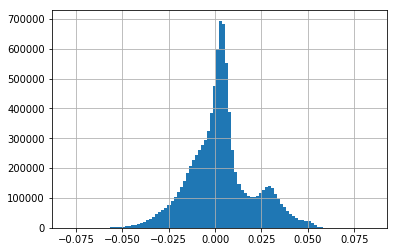

In [30]:
(d['201809']/b['201809']-1).hist(bins=100)

In [32]:
(d['201809']/b['201809']-1).median()

0.0026172053801369888

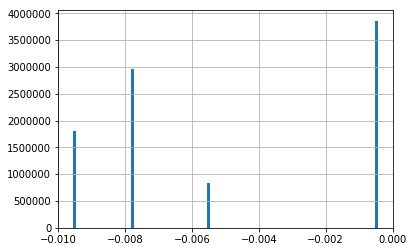

In [18]:
(a['201809']/c['201809']-1).hist(bins=100)

In [41]:
(a['201810']/b['201810']-1).describe()

count    9.463185e+06
mean     2.251056e-03
std      1.890642e-02
min     -1.000269e-01
25%     -9.341846e-03
50%      3.376439e-03
75%      1.290634e-02
max      8.143122e-02
Name: 201810, dtype: float64

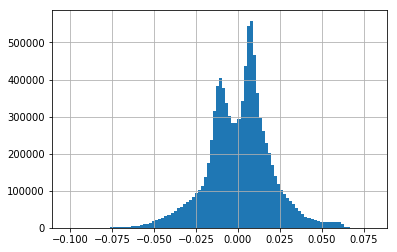

In [31]:
(d['201810']/b['201810']-1).hist(bins=100)

In [33]:
(d['201810']/b['201810']-1).median()

0.0026455975965906653

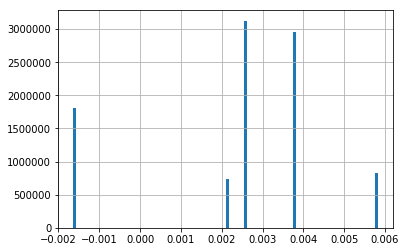

In [21]:
(a['201810']/c['201810']-1).hist(bins=100)

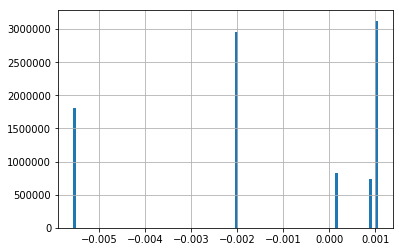

In [22]:
((a['201810']+a['201809'])/(c['201810']+c['201809'])-1).hist(bins=100)

In [46]:
        fs04ctst = info.get_county_fs04ctst()['county_name'].to_dict()


In [37]:
counties=pd.concat([features.get('county',u,2018) for u in config.STATES])['county'].to_dict()

In [38]:
dd=(d['201810']/b['201810']-1).to_frame()

In [41]:
dd['county']=dd.index.map(lambda u: np.nan if u not in counties else counties[u])

In [51]:
dd=dd.dropna()
dd['state']=dd.county.map(lambda u:u[:2])

/home/lizhen09/miniconda2/envs/python27/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [56]:
x=dd.groupby("state").mean().sort_values('201810')

In [57]:
x

201810
state          
37    -0.011576
06     0.000440
39     0.006880
19     0.009622
36     0.017960

In [58]:
x=dd.groupby("county").mean().sort_values('201810')

In [59]:
x['name']=x.index.map(lambda u: fs04ctst[u])

In [60]:
x

201810                 name
county                               
37169  -0.026013        Stokes County
37063  -0.023275        Durham County
37059  -0.022932         Davie County
37021  -0.022925      Buncombe County
37115  -0.022482       Madison County
37175  -0.022190  Transylvania County
37025  -0.020892      Cabarrus County
37199  -0.020575        Yancey County
37001  -0.020075      Alamance County
37043  -0.019713          Clay County
37119  -0.019614   Mecklenburg County
37099  -0.018363       Jackson County
37055  -0.017813          Dare County
37067  -0.017518       Forsyth County
37109  -0.017109       Lincoln County
37071  -0.016316        Gaston County
37183  -0.016070          Wake County
37069  -0.016046      Franklin County
37003  -0.015701     Alexander County
37179  -0.015198         Union County
37173  -0.014756         Swain County
37075  -0.014143        Graham County
37039  -0.014118      Cherokee County
37145  -0.013740        Person County
37077  -0.013673     Granville County
37057  -0.013562      Davidson County
37073  -0.013529         Gates County
37089  -0.013497     Henderson County
37121  -0.013475      Mitchell County
37113  -0.012887         Macon County
...          ...                  ...
39013   0.011973       Belmont County
19193   0.012031      Woodbury County
39017   0.012100        Butler County
19081   0.012118       Hancock County
39091   0.012389         Logan County
19181   0.012420        Warren County
19005   0.013091     Allamakee County
39131   0.013158          Pike County
39029   0.013165    Columbiana County
39125   0.013175      Paulding County
19189   0.013193     Winnebago County
39007   0.013324     Ashtabula County
19043   0.013583       Clayton County
39145   0.013930        Scioto County
19139   0.013997     Muscatine County
19033   0.014197   Cerro Gordo County
19013   0.014257    Black Hawk County
19115   0.014770        Louisa County
19127   0.015527      Marshall County
39087   0.015765      Lawrence County
36081   0.015819        Queens County
39155   0.017260      Trumbull County
39099   0.017460      Mahoning County
36085   0.017482      Richmond County
36047   0.017594         Kings County
39167   0.017739    Washington County
19059   0.018090     Dickinson County
36005   0.018420         Bronx County
19061   0.020661       Dubuque County
36061   0.025155      New York County

[207 rows x 2 columns]